In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import subprocess

try:
    import japanize_matplotlib
    print("japanize_matplotlib is already installed.")
except ImportError:
    !pip install japanize_matplotlib
    print("japanize_matplotlib has been installed.")

try:
    import catboost
    print("catboost is already installed.")
except ImportError:
    !pip install catboost
    print("catboost has been installed.")

try:
    import optuna
    print("optuna is already installed.")
except ImportError:
    !pip install optuna
    print("optuna has been installed.")

try:
    import geolib
    print("geolib is already installed.")
except ImportError:
    !pip install geolib
    print("geolib has been installed.")

!pip install statsmodels==0.14.0


# mkdirとechoコマンドの実行
try:
    subprocess.check_call('mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd', shell=True)
    print('Directory and file for OpenCL vendors have been created.')
except subprocess.CalledProcessError as e:
    print(f"Error running mkdir and echo command: {e}")

japanize_matplotlib is already installed.
catboost is already installed.
optuna is already installed.
geolib is already installed.
Directory and file for OpenCL vendors have been created.


In [16]:
import sys
sys.path.append('/content/drive/MyDrive/yuto/project_directory/code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from itertools import product
from typing import Union
import japanize_matplotlib
import seaborn
import glob
import pickle
import optuna


from utils import (
                   Multiple_Charts,
                   optimize_SARIMA,
                   ProcessData,
                   trans_chara,
                   fill_missing_values,
                   fill_missing_with_mode,
                   find_nearest_station_main_table,
                   calculate_distance,
                   convert_kanji_to_fullwidth_2,
                   encode_geohash,
                   to_cat_col,
                   TreeExecution,
                   check_dataframe_elements
                   )

TOTAL_PRICE_LOG="取引価格（総額）_log"
PRICE_PER_AREA_LOG="単位面積あたりの取引価格_log"

TARGET="単位面積あたりの取引価格_log"

In [17]:
files = glob.glob(
    r"/content/drive/MyDrive/Colab Notebooks/中古マンション価格予測_2024年夏/ダウンロードデータ/学習用データ/*.csv")
data_list = []
for file in files:
    data_list.append(pd.read_csv(file, index_col=0))
df = pd.concat(data_list)
df_copy=df.copy()
check_dataframe_elements(df)

df_test=pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/中古マンション価格予測_2024年夏/ダウンロードデータ/test.csv",index_col=0)
df_test_copy=df_test.copy()


# カラム 'A' の欠損値の数を確認
tre_missing_values_count = df['最寄駅：名称'].isnull().sum()
tes_missing_values_count = df_test['最寄駅：名称'].isnull().sum()
print(f"学習データの欠損値の数: {tre_missing_values_count}")
print(f"テストデータの欠損値の数: {tes_missing_values_count}")

<ipython-input-17-a1f61ee0ec5f>:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_list.append(pd.read_csv(file, index_col=0))
<ipython-input-17-a1f61ee0ec5f>:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_list.append(pd.read_csv(file, index_col=0))


<class 'pandas.core.frame.DataFrame'>
Index: 1009271 entries, 37000457 to 6009259
Data columns (total 28 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   種類            1009271 non-null  object 
 1   価格情報区分        1009271 non-null  object 
 2   地域            0 non-null        float64
 3   市区町村コード       1009271 non-null  int64  
 4   都道府県名         1009271 non-null  object 
 5   市区町村名         1009271 non-null  object 
 6   地区名           1008610 non-null  object 
 7   最寄駅：名称        998620 non-null   object 
 8   最寄駅：距離（分）     964322 non-null   object 
 9   間取り           976570 non-null   object 
 10  面積（㎡）         1009271 non-null  object 
 11  土地の形状         0 non-null        float64
 12  間口            0 non-null        float64
 13  延床面積（㎡）       0 non-null        float64
 14  建築年           979931 non-null   object 
 15  建物の構造         977046 non-null   object 
 16  用途            734705 non-null   object 
 17  今後の利用目的       463475 non-

In [18]:
data_tree=ProcessData(df,df_test)
df_train_tree,df_test_tree,df_all_tree,df_geo,cat_cols=data_tree.return_data_test()

MultiIndex([('train', 37000457),
            ('train', 37011047),
            ('train', 37018527),
            ('train', 37013457),
            ('train', 37037251),
            ('train', 37007410),
            ('train', 37021494),
            ('train', 37006258),
            ('train', 37021474),
            ('train', 37011052),
            ...
            ( 'test', 47036042),
            ( 'test', 47036043),
            ( 'test', 47036044),
            ( 'test', 47036616),
            ( 'test', 47036619),
            ( 'test', 47036620),
            ( 'test', 47037115),
            ( 'test', 47037850),
            ( 'test', 47037855),
            ( 'test', 47037856)],
           names=[None, 'ID'], length=1063673)


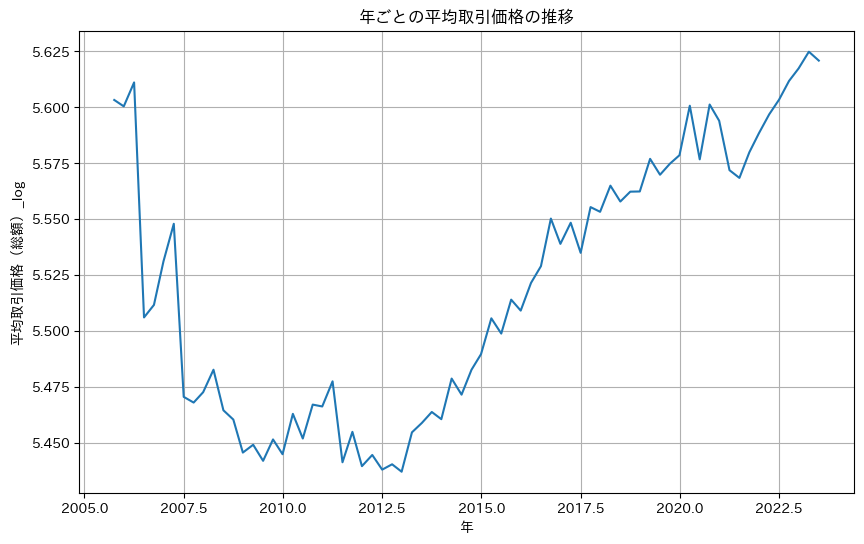

In [19]:
average_price_per_year=df_train_tree.groupby("取引時点")[f"{TARGET}"].mean()

# 可視化
plt.figure(figsize=(10, 6))
average_price_per_year.plot(kind='line')
plt.title('年ごとの平均取引価格の推移')
plt.xlabel('年')
plt.ylabel('平均取引価格（総額）_log')
plt.grid(True)
plt.show()

In [20]:
# 「取引時点」カラムをエンコードして、各ユニークな取引時点を整数に変換する処理
enc_dic = {}
for i, e in enumerate(sorted(list(set(df_all_tree['取引時点'].values)))):
    enc_dic[e] = i
df_all_tree['取引時点_enc'] = df_all_tree['取引時点'].map(enc_dic)

# 時間的な特徴と地域（都道府県名）に基づいたターゲット変数の過去の平均値を計算し、それを辞書に保存する
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df_all_tree[time_col].values):
    tmp_df = df_all_tree[df_all_tree[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

# te_dic[50] の出力例
# { '北海道': 3.5, '青森県': 2.8, ... }

def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df_all_tree[group_col+'_te'] = df_all_tree.apply(calc_te, axis=1)
df_all_tree.head(2)

価格情報区分 都道府県名 市区町村名  地区名   最寄駅：名称  最寄駅：距離（分）   間取り  面積（㎡）  \
      ID                                                                      
train 37000457     成約価格情報   香川県   高松市  西宝町  昭和町(香川)        7.0  ３ＬＤＫ   80.0   
      37011047  不動産取引価格情報   香川県   高松市   桜町       栗林        2.0    １Ｋ   25.0   

                  建築年 建物の構造  ...    築年数 log_面積（㎡） 購入までの築年数  面積（㎡）-最寄駅：距離（分）  \
      ID                     ...                                              
train 37000457  2005年    ＲＣ  ...  18.99  4.382027    18.50             73.0   
      37011047  1985年    ＲＣ  ...  38.99  3.218876    30.99             23.0   

                面積（㎡）-築年数  面積（㎡）容積率（％）_combi 旧耐震フラグ 単位面積あたりの取引価格_log  \
      ID                                                               
train 37000457      61.01                NaN      0         5.458638   
      37011047     -13.99             7500.0      0         4.880814   

                取引時点_enc  都道府県名_te  
      ID                            
train 37000457        71  5.156080  
      37011047        41  5.127462  

[2 rows x 30 columns]

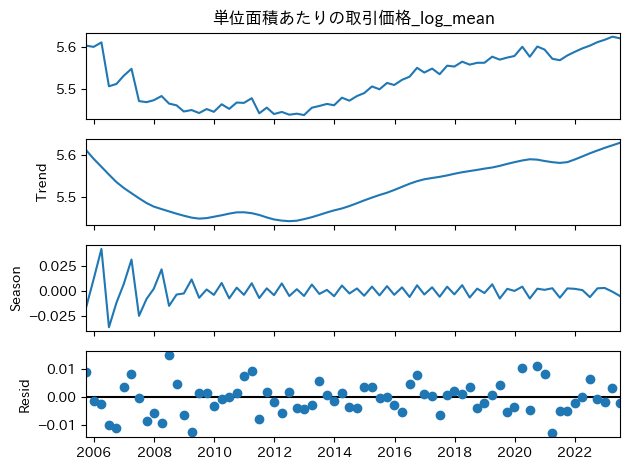

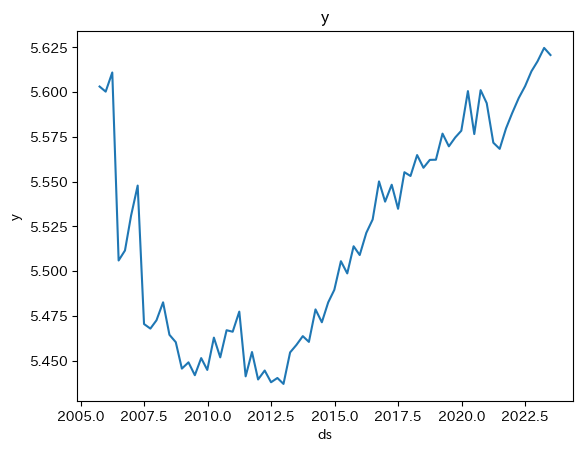

In [21]:
df_train_tree_=df_train_tree.copy()
df_year=df_train_tree_.groupby("取引時点")[f"{TARGET}"].mean().rename(f"{TARGET}_mean")

decomposition=STL(df_year,period=4).fit().plot()
plt.show()

graph=Multiple_Charts(df_year)
graph.year_price_test()
plt.show()

In [22]:
ADF_result=adfuller(df_year.values)
print(f"ADF Staistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF Staistic: -0.7058994452258287
p-value: 0.8452155249526752


ADF Staistic: -2.7700984933049284
p-value: 0.06267355651987336


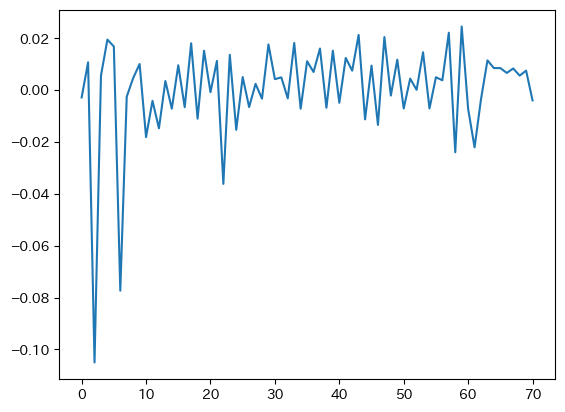

In [23]:
df_diff=np.diff(df_year.values,n=1)
ADF_result=adfuller(df_diff)
print(f"ADF Staistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")
graph2=Multiple_Charts(df_diff)
graph2.graph_multiple_array()
plt.show()

ADF Staistic: -5.730190430885435
p-value: 6.627737807665314e-07


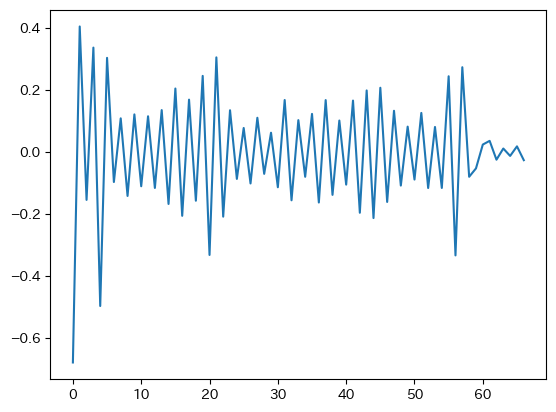

In [24]:
df_diff_seasonal_diff=np.diff(df_diff,n=4)
ADF_result=adfuller(df_diff_seasonal_diff)
print(f"ADF Staistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")
graph3=Multiple_Charts(df_diff_seasonal_diff)
graph3.graph_multiple_array()

In [25]:
#print(abc)

  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dat

Error fitting model: LU decomposition error.


ストリーミング出力は最後の 5000 行に切り捨てられました。
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. for

Error fitting model: LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be igno

Error fitting model: LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  

モデルの保存が完了しました。


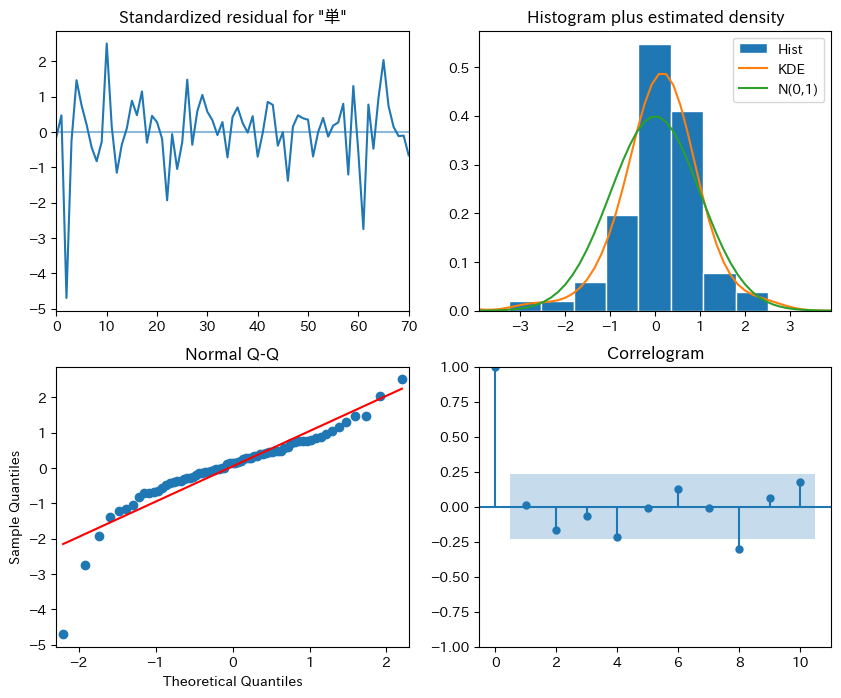

In [26]:
ps=range(0,4,1)
qs=range(0,4,1)
Ps=range(0,4,1)
Qs=range(0,4,1)
d=range(0,3,1)
D=range(0,3,1)
s=4

SARIMAX_order_list=list(product(ps,qs,Ps,Qs))
d_list=list(product(d))
D_list=list(product(D))

SARIMAX_result_df,best_params, best_aic=optimize_SARIMA(df_year,SARIMAX_order_list,d_list,D_list,s)
SARIMAX_result_df###
best_params=[0,1,1,1,0,0]
best_params=[0,1,1,1,0,1]
#SARIMA_model=SARIMAX(df_year,order=(0,1,1),seasonal_order=(1,0,1,4))
# SARIMAモデルを作成
SARIMA_model = SARIMAX(df_year, order=(best_params[0], best_params[1], best_params[2]),
                       seasonal_order=(best_params[3], best_params[4], best_params[5], s),
                       simple_differencing=False)
SARIMA_model_fit=SARIMA_model.fit()

# モデルの保存
model_path = r"/content/drive/MyDrive/yuto/project_directory/models/sub_sarimax.pkl"
with open(model_path, 'wb') as file:
    pickle.dump(SARIMA_model_fit, file)

print("モデルの保存が完了しました。")

SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

residuals=SARIMA_model_fit.resid
result_df=acorr_ljungbox(residuals,np.arange(1,11,1))
result_df

SARIMA_pred=SARIMA_model_fit.get_forecast(steps=2)
SARIMA_pred_df=SARIMA_pred.summary_frame()###

SARIMA_pred_df.to_csv(r"/content/drive/MyDrive/yuto/project_directory/data/intermediate_results/checkpoints/sub_df_arima_mean.csv")

In [27]:
df_all_year=df_all_tree.groupby("取引時点")[f"{TARGET}"].mean().rename(f"{TARGET}_mean")
# 最後のインデックスに続けて新しい値を追加
last_index = df_all_year.index[-1]  # 最後のインデックスを取得
print(df_all_year.index)

Index([2005.75, 2005.99, 2006.25,  2006.5, 2006.75, 2006.99, 2007.25,  2007.5,
       2007.75, 2007.99, 2008.25,  2008.5, 2008.75, 2008.99, 2009.25,  2009.5,
       2009.75, 2009.99, 2010.25,  2010.5, 2010.75, 2010.99, 2011.25,  2011.5,
       2011.75, 2011.99, 2012.25,  2012.5, 2012.75, 2012.99, 2013.25,  2013.5,
       2013.75, 2013.99, 2014.25,  2014.5, 2014.75, 2014.99, 2015.25,  2015.5,
       2015.75, 2015.99, 2016.25,  2016.5, 2016.75, 2016.99, 2017.25,  2017.5,
       2017.75, 2017.99, 2018.25,  2018.5, 2018.75, 2018.99, 2019.25,  2019.5,
       2019.75, 2019.99, 2020.25,  2020.5, 2020.75, 2020.99, 2021.25,  2021.5,
       2021.75, 2021.99, 2022.25,  2022.5, 2022.75, 2022.99, 2023.25,  2023.5,
       2023.75, 2023.99],
      dtype='float64', name='取引時点')


In [28]:
print(df_all_year)
df_all_year.loc[2023.75]=SARIMA_pred_df["mean"][72]
df_all_year.loc[2023.99]=SARIMA_pred_df["mean"][73]

df_all_year.to_csv(r"/content/drive/MyDrive/yuto/project_directory/data/intermediate_results/checkpoints/pred_時系列mean_colabo.csv")

取引時点
2005.75    5.603129
2005.99    5.600274
2006.25    5.610975
2006.50    5.505956
2006.75    5.511552
             ...   
2022.99    5.617195
2023.25    5.624689
2023.50    5.620718
2023.75         NaN
2023.99         NaN
Name: 単位面積あたりの取引価格_log_mean, Length: 74, dtype: float64


In [29]:
df_all_year

,単位面積あたりの取引価格_log_mean
取引時点,
2005.75,5.603129
2005.99,5.600274
2006.25,5.610975
2006.50,5.505956
2006.75,5.511552
...,...
2022.99,5.617195
2023.25,5.624689
2023.50,5.620718
